In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [2]:
def fourier_sample(rng, n, p, n_freq = 20, intercept = True):
    x = jnp.linspace(0, 1, p)
    f = 0
    for i in range(n_freq):
        rng, key1, key2 = random.split(rng, 3)
        
        an = 1/(i+1) * random.normal(key1, (n, 1))
        bn = 1/(i+1) * random.normal(key2, (n, 1))

        f += an * jnp.cos(2*math.pi * i * x)[None,]
        f += bn * jnp.sin(2*math.pi * i * x)[None,]

    if intercept:
        f += random.normal(rng, (n, 1))
    return f

In [3]:
def phi_slice(rng, p1, p2):
    phi = random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi
    
def phi_depth(z, x, w, depth_fn):
    if depth_fn == 'tukey':
        f = jnp.sum(w[:,None] * (z > x), axis = 0)
        depth_1d = 1 - jnp.abs(1 - 2 * f)
    
    elif depth_fn == 'mahal':
        mu = jnp.sum(w[:,None]*x, axis = 0)
        sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
        depth_1d = 1/(1+jnp.sqrt((z - mu)**2/sig**2))
        
    elif depth_fn == 'norm':
        norms = jnp.abs(z - x)
        wnorm = jnp.sum(w[:,None] * norms, axis = 0)
        depth_1d = 1/(1+wnorm)

    else: return 0
    return jnp.min(depth_1d)

phi_depth = jit(phi_depth, static_argnames='depth_fn')
vphi_depth = jit(vmap(phi_depth, (0, None, None, None)), static_argnames='depth_fn')

def localizer(xval, xtest, lam, local_fn, self, rng):
    
    if local_fn == 'dexp':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtest), axis = (1, 2))
        dist = dist / jnp.max(dist)
        dist = jnp.exp(-lam * dist)
        local_weights = dist / (jnp.sum(dist) + ind * jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'gaussian':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.mean((xval - xtest)**2, axis = (1, 2))
        dist = dist / jnp.max(dist)
        dist = jnp.exp(-lam * dist)
        local_weights = dist / (jnp.sum(dist) + ind * jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'knn':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtest), axis = (1, 2))
        dist = dist / jnp.max(dist)
        qdist = jnp.quantile(dist, lam)
        dist = jnp.exp(-dist.at[dist > qdist].set(jnp.inf))
        local_weights = dist / (jnp.sum(dist))
        
    else :
        local_weights = 1/xval.shape[0]
    return local_weights

def lsci_quantile(rval_phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng):

    local_weights = localizer(xval, xtest, lam, local_fn, True, rng)
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)

    n = jnp.sum(local_weights > 0)
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return dval, jnp.quantile(dval, 1-adj_alpha), local_weights

def lsci_sampler(xval, xtest, rval_phi, n_samp, local_fn, lam, rng):
    
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    local_weights = localizer(xval, xtest, lam, local_fn, False, rng)
    
    unif = random.uniform(rng, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    return samp_phi

In [4]:
# scaled metrics
def scaled_linf_dist(x, y):
    d = jnp.max(jnp.abs(x - y))
    return d/(1+d)
scaled_linf_dist = jit(vmap(vmap(scaled_linf_dist, (0, None)), (None, 0)))

def scaled_l2_dist(x, y):
    d = jnp.sqrt(jnp.mean((x - y)**2))
    return d/(1+d)
scaled_l2_dist = jit(vmap(vmap(scaled_l2_dist, (0, None)), (None, 0)))

# localizers
def linf_localizer(xval, xtest, lam):
    dist = scaled_linf_dist(xval, xtest)
    dist = jnp.exp(-lam * dist)
    local_weights = dist / (jnp.exp(-lam) + jnp.sum(dist, axis = 1, keepdims=True))
    return local_weights

def l2_localizer(xval, xtest, lam):
    dist = scaled_l2_dist(xval, xtest)
    dist = jnp.exp(-lam * dist)
    local_weights = dist / (jnp.exp(-lam) + jnp.sum(dist, axis = 1, keepdims=True))
    return local_weights

def knn_localizer(xval, xtest, lam):
    dist = scaled_l2_dist(xval, xtest)
    qdist = jnp.quantile(dist, 1/(1+lam))
    dist = jnp.exp(-dist.at[dist > qdist].set(qdist))
    local_weights = dist / (jnp.exp(-1/lam) + jnp.sum(dist, axis = 1, keepdims=True))
    return local_weights

# phi depths
def weighted_tukey1d(phi_val, phi_test, weights):
    f1 = jnp.sum(weights * (phi_val < phi_test))
    f2 = jnp.sum(weights * (phi_val > phi_test))
    f = jnp.vstack([f1, f2])
    return 2*jnp.min(f)
weighted_tukey1d = vmap(weighted_tukey1d, (None, 0, None))
weighted_tukey1d = vmap(weighted_tukey1d, (1, 1, None))
weighted_tukey1d = jit(weighted_tukey1d)

def weighted_norm1d(phi_val, phi_test, weights):
    f = jnp.sum(weights * jnp.abs(phi_val - phi_test))
    f = jnp.nan_to_num(f)
    return 1/(1 + f)
weighted_norm1d = vmap(weighted_norm1d, (None, 0, None))
weighted_norm1d = vmap(weighted_norm1d, (1, 1, None))
weighted_norm1d = jit(weighted_norm1d)

def weighted_mahal1d(phi_val, phi_test, weights):
    f = jnp.sum(weights * jnp.abs(phi_val - phi_test) / jnp.std(phi_val))
    f = jnp.nan_to_num(f)
    return 1/(1 + f)
weighted_mahal1d = vmap(weighted_mahal1d, (None, 0, None))
weighted_mahal1d = vmap(weighted_mahal1d, (1, 1, None))
weighted_mahal1d = jit(weighted_mahal1d)

def phi_tukey(phi_val, phi_test, weights):
    depth = jnp.min(weighted_tukey1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
phi_tukey = vmap(phi_tukey, (None, None, 0))
phi_tukey = jit(phi_tukey)

def phi_norm(phi_val, phi_test, weights):
    depth = jnp.min(weighted_norm1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
phi_norm = vmap(phi_norm, (None, None, 0))
phi_norm = jit(phi_norm)

def phi_mahal(phi_val, phi_test, weights):
    depth = jnp.min(weighted_mahal1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
phi_mahal = vmap(phi_mahal, (None, None, 0))
phi_mahal = jit(phi_mahal)

## diagonal versions
def vphi_tukey(phi_val, phi_test, weights):
    depth = jnp.min(weighted_tukey1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
vphi_tukey = vmap(vphi_tukey, (None, 0, 0))
vphi_tukey = jit(vphi_tukey)

def vphi_norm(phi_val, phi_test, weights):
    depth = jnp.min(weighted_norm1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
vphi_norm = vmap(vphi_norm, (None, 0, 0))
vphi_norm = jit(vphi_norm)

def vphi_mahal(phi_val, phi_test, weights):
    depth = jnp.min(weighted_mahal1d(phi_val, phi_test, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
vphi_mahal = vmap(vphi_mahal, (None, 0, 0))
vphi_mahal = jit(vphi_mahal)

In [5]:
### sampler
def local_cdf(x, q, weights):
    f = jnp.sum(weights * (x < q))
    return f
local_cdf = jit(vmap(local_cdf, (None, 0, None)))

def local_quantile(x, cdf, unif):
    return x[jnp.argmax(cdf > unif)]
local_quantile = jit(vmap(local_quantile, (None, None, 0)))

def local_sampler(x, weights, n_samp, rng):
    quants = jnp.linspace(jnp.min(x) - 0.1, jnp.max(x) + 0.1, x.shape[0]+1)
    unif = random.uniform(rng, n_samp)
    lcdf = local_cdf(x, quants, w.T)
    return local_quantile(x, lcdf, unif)
local_sampler = vmap(local_sampler, in_axes = (1, None, None, 0), out_axes = 1)
local_sampler = vmap(local_sampler, (None, 0, None, 1), out_axes = 0)

def pcax_recover(state, ens):
    return pcax.recover(state, ens)
pcax_recover = vmap(pcax_recover, (None, 0))

def phi_project(ens, phi):
    return ens @ phi
vphi_project = vmap(phi_project, (0, None))

def phi_band(ens, depths, thresh):
    sub_ens = ens
    sub_ens = sub_ens.at[depths >= thresh].set(jnp.nan)
    lower = jnp.nanmin(sub_ens, axis = 0)
    upper = jnp.nanmax(sub_ens, axis = 0)
    return jnp.stack([lower, upper])

In [6]:
# rng = random.PRNGKey(0)
# rng, key1, key2 = random.split(rng, 3)
# x1 = fourier_sample(key1, ntrain, p, n_freq, False)
# x2 = fourier_sample(key2, ntest, p, n_freq, False)

# t = jnp.linspace(0, 1, ntrain+ntest)
# mu = 1 + jnp.sin(6 * jnp.pi * t)

# x1 = mu[:ntrain,None] + x1
# x2 = mu[ntrain:,None] + x2

# rng, key1, key2, key3, key4 = random.split(rng, 5)
# y1 = mu[:ntrain,None] + fourier_sample(key1, ntrain, p, n_freq, False)
# y2 = mu[ntrain:,None] + fourier_sample(key2, ntest, p, n_freq, False)

In [7]:
rng = random.PRNGKey(0)

In [8]:
# rng, key3, key4 = random.split(rng, 3)

# # unpack
# lam = 1

# local_weights = linf_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
# phi = phi_slice(key4, p, 100)
# p1 = y1 @ phi
# p2 = y2 @ phi

# k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
# d1 = phi_norm(p1, p1, local_weights) - 1/ntrain
# q1 = jnp.quantile(d1, 1-k, axis = 1)
# d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
# np.mean(d2 > q1)

In [9]:
ntrain, ntest, p, n_freq = 1000, 500, 100, 21   
alpha = 0.1
n_set = 5
n_sim = 100

rng = random.PRNGKey(0)
cover_linf = np.zeros((n_set, n_sim, ntest))
cover_l2 = np.zeros((n_set, n_sim, ntest))
cover_knn = np.zeros((n_set, n_sim, ntest))

lams = [{'lam': 0.50}, 
        {'lam': 1.00}, 
        {'lam': 2.00}, 
        {'lam': 4.00}, 
        {'lam': 8.00}]

for i in trange(n_sim):
    rng, key1, key2 = random.split(rng, 3)
    x1 = fourier_sample(key1, ntrain, p, n_freq, False)
    x2 = fourier_sample(key2, ntest, p, n_freq, False)
    
    t = jnp.linspace(0, 1, ntrain+ntest)
    mu = 1 + jnp.sin(6 * jnp.pi * t)
    
    x1 = mu[:ntrain,None] + x1
    x2 = mu[ntrain:,None] + x2
    
    rng, key1, key2, key3, key4 = random.split(rng, 5)
    y1 = mu[:ntrain,None] + fourier_sample(key1, ntrain, p, n_freq, False)
    y2 = mu[ntrain:,None] + fourier_sample(key2, ntest, p, n_freq, False)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = linf_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_tukey(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
        cover_linf[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = l2_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_tukey(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
        cover_l2[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = knn_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_tukey(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
        cover_knn[s, i] = (d2 > q1)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [73]:
print(np.round(np.mean(np.mean(cover_linf, axis = 2), axis = 1), 3))
print(np.round(np.mean(np.mean(cover_l2, axis = 2), axis = 1), 3))
print(np.round(np.mean(np.mean(cover_knn, axis = 2), axis = 1), 3))

[0.905 0.905 0.904 0.906 0.905]
[0.903 0.904 0.903 0.905 0.908]
[0.904 0.901 0.902 0.897 0.897]


In [74]:
print(np.round(2 * np.std(np.mean(cover_linf, axis = 2), axis = 1), 2))
print(np.round(2 * np.std(np.mean(cover_l2, axis = 2), axis = 1), 2))
print(np.round(2 * np.std(np.mean(cover_knn, axis = 2), axis = 1), 2))

[0.03 0.03 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.04]


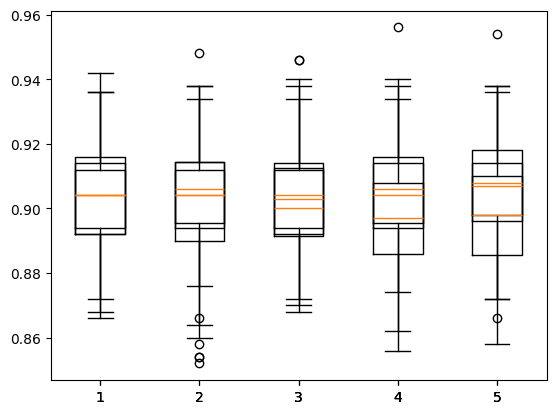

In [75]:
plt.boxplot(np.mean(cover_linf, axis = 2).T)
plt.boxplot(np.mean(cover_l2, axis = 2).T)
plt.boxplot(np.mean(cover_knn, axis = 2).T)
plt.show()

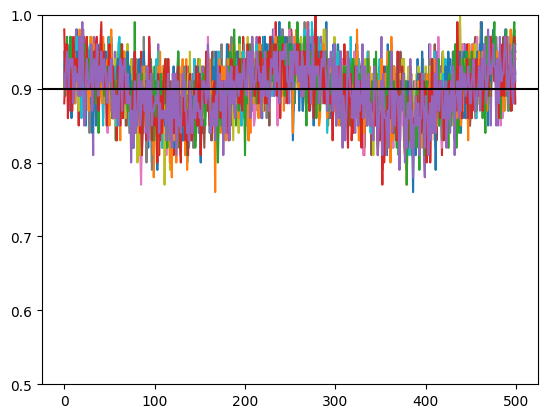

NameError: name 'cover' is not defined

In [76]:
plt.plot(np.mean(cover_linf, axis = 1).T)
plt.plot(np.mean(cover_l2, axis = 1).T)
plt.plot(np.mean(cover_knn, axis = 1).T)
plt.axhline(0.9, c = 'black')
plt.ylim(0.5, 1)
plt.show()
np.mean(cover)

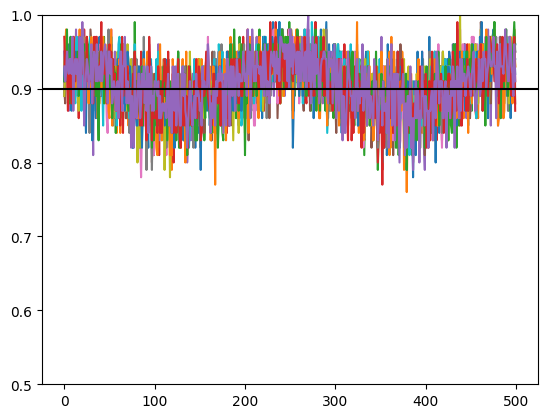

np.float64(0.902996)

In [875]:
plt.plot(np.mean(cover_linf, axis = 1).T)
plt.plot(np.mean(cover_l2, axis = 1).T)
plt.plot(np.mean(cover_knn, axis = 1).T)
plt.axhline(0.9, c = 'black')
plt.ylim(0.5, 1)
plt.show()
np.mean(cover)

In [42]:
ntrain, ntest, p, n_freq = 1000, 500, 100, 21   
alpha = 0.1
n_set = 5
n_sim = 100

rng = random.PRNGKey(0)
cover_linf = np.zeros((n_set, n_sim, ntest))
cover_l2 = np.zeros((n_set, n_sim, ntest))
cover_knn = np.zeros((n_set, n_sim, ntest))

lams = [{'lam': 0.50}, 
        {'lam': 1.00}, 
        {'lam': 2.00}, 
        {'lam': 4.00}, 
        {'lam': 8.00}]

for i in trange(n_sim):
    rng, key1, key2 = random.split(rng, 3)
    x1 = fourier_sample(key1, ntrain, p, n_freq, False)
    x2 = fourier_sample(key2, ntest, p, n_freq, False)
    
    t = jnp.linspace(0, 1, ntrain+ntest)
    mu = 1 + jnp.sin(6 * jnp.pi * t)
    
    x1 = mu[:ntrain,None] + x1
    x2 = mu[ntrain:,None] + x2
    
    rng, key1, key2, key3, key4 = random.split(rng, 5)
    y1 = mu[:ntrain,None] + fourier_sample(key1, ntrain, p, n_freq, False)
    y2 = mu[ntrain:,None] + fourier_sample(key2, ntest, p, n_freq, False)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = linf_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_norm(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_norm(p1, p2, local_weights))
        cover_linf[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = l2_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_norm(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_norm(p1, p2, local_weights))
        cover_l2[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = knn_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_norm(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_norm(p1, p2, local_weights))
        cover_knn[s, i] = (d2 > q1)

  0%|          | 0/100 [00:00<?, ?it/s]

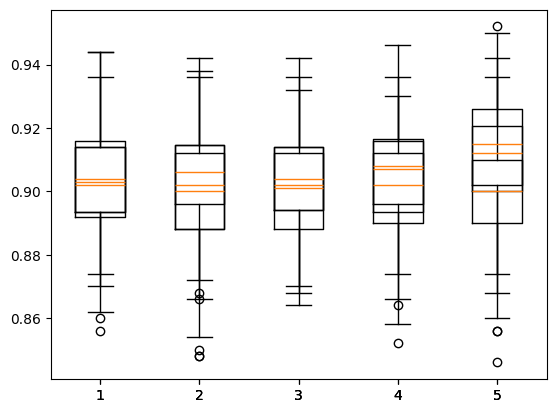

(np.float64(0.904436), np.float64(0.906436), np.float64(0.90102))

In [43]:
plt.boxplot(np.mean(cover_linf, axis = 2).T)
plt.boxplot(np.mean(cover_l2, axis = 2).T)
plt.boxplot(np.mean(cover_knn, axis = 2).T)
plt.show()
np.mean(cover_linf), np.mean(cover_l2), np.mean(cover_knn)

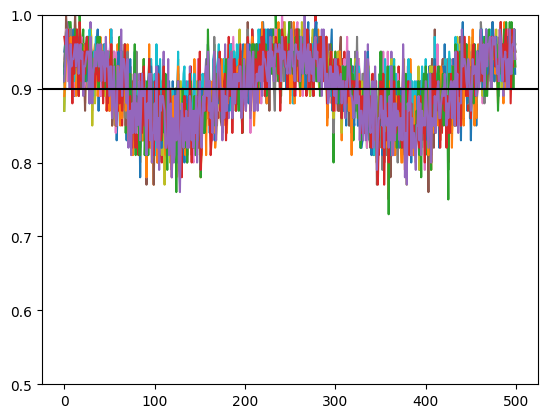

In [44]:
plt.plot(np.mean(cover_linf, axis = 1).T)
plt.plot(np.mean(cover_l2, axis = 1).T)
plt.plot(np.mean(cover_knn, axis = 1).T)
plt.axhline(0.9, c = 'black')
plt.ylim(0.5, 1)
plt.show()

In [46]:
print(np.round(np.mean(np.mean(cover_linf, axis = 2), axis = 1), 3))
print(np.round(np.mean(np.mean(cover_l2, axis = 2), axis = 1), 3))
print(np.round(np.mean(np.mean(cover_knn, axis = 2), axis = 1), 3))

[0.904 0.9   0.903 0.905 0.91 ]
[0.903 0.905 0.903 0.907 0.914]
[0.903 0.901 0.902 0.9   0.899]


In [47]:
print(np.round(2 * np.std(np.mean(cover_linf, axis = 2), axis = 1), 2))
print(np.round(2 * np.std(np.mean(cover_l2, axis = 2), axis = 1), 2))
print(np.round(2 * np.std(np.mean(cover_knn, axis = 2), axis = 1), 2))

[0.03 0.03 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.03]
[0.03 0.04 0.03 0.03 0.03]


In [49]:
ntrain, ntest, p, n_freq = 1000, 500, 100, 21   
alpha = 0.1
n_set = 5
n_sim = 100

rng = random.PRNGKey(0)
cover_linf = np.zeros((n_set, n_sim, ntest))
cover_l2 = np.zeros((n_set, n_sim, ntest))
cover_knn = np.zeros((n_set, n_sim, ntest))

lams = [{'lam': 0.50}, 
        {'lam': 1.00}, 
        {'lam': 2.00}, 
        {'lam': 4.00}, 
        {'lam': 8.00}]

for i in trange(n_sim):
    rng, key1, key2 = random.split(rng, 3)
    x1 = fourier_sample(key1, ntrain, p, n_freq, False)
    x2 = fourier_sample(key2, ntest, p, n_freq, False)
    
    t = jnp.linspace(0, 1, ntrain+ntest)
    mu = 1 + jnp.sin(6 * jnp.pi * t)
    
    x1 = mu[:ntrain,None] + x1
    x2 = mu[ntrain:,None] + x2
    
    rng, key1, key2, key3, key4 = random.split(rng, 5)
    y1 = mu[:ntrain,None] + fourier_sample(key1, ntrain, p, n_freq, False)
    y2 = mu[ntrain:,None] + fourier_sample(key2, ntest, p, n_freq, False)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = linf_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_mahal(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_mahal(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_norm(p1, p2, local_weights))
        cover_linf[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = l2_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_mahal(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_mahal(p1, p2, local_weights))
        cover_l2[s, i] = (d2 > q1)

    ## loop over settings
    for s in range(n_set):
        rng, key3, key4 = random.split(rng, 3)
        
        # unpack
        lam = lams[s]['lam']
        
        local_weights = knn_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
        phi = phi_slice(key4, p, 100)
        p1 = y1 @ phi
        p2 = y2 @ phi
    
        k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
        d1 = phi_mahal(p1, p1, local_weights)
        q1 = jnp.quantile(d1, 1-k, axis = 1)
        d2 = jnp.diag(phi_mahal(p1, p2, local_weights))
        cover_knn[s, i] = (d2 > q1)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [ ]:
weight = local_weights(xval2, xtest2, gamma).squeeze()
unif = random.uniform(rng, (nsamp, npc))
quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, nval+1)

local_cdfs = lcdf(rval2, quants, weight)
local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
local_phi = quants[local_quants].T

In [13]:
rng, key1, key2 = random.split(rng, 3)
x1 = fourier_sample(key1, ntrain, p, n_freq, False)
x2 = fourier_sample(key2, ntest, p, n_freq, False)

t = jnp.linspace(0, 1, ntrain+ntest)
mu = 1 + jnp.sin(6 * jnp.pi * t)

x1 = mu[:ntrain,None] + x1
x2 = mu[ntrain:,None] + x2

rng, key1, key2, key3, key4 = random.split(rng, 5)
r1 = mu[:ntrain,None] + fourier_sample(key1, ntrain, p, n_freq, False)
r2 = mu[ntrain:,None] + fourier_sample(key2, ntest, p, n_freq, False)

In [14]:
import pcax
n_proj = 40
n_samp = 2000

In [15]:
lweights = l2_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), 5).T

state = pcax.fit(y1, n_components = n_proj)
r1_phi = pcax.transform(state, r1)
r2_phi = pcax.transform(state, r2)

rng = random.PRNGKey(0)
rns = random.split(rng, (n_proj, lweights.shape[1]))
ens = local_sample(r1_phi, lweights, n_samp, rns)
ens.shape
# ens = pcax_recover(state, ens)

# k = jnp.ceil((n+1)*(1-alpha))/n
# depth_cal = phi_tukey(r1, r1, lweights.T)
# quant_cal = jnp.quantile(depth_cal, 1-k, axis = 1)
# depth_ens = phi_tukey_diag(r1, ens, lweights)

# lsci_bands = jnp.array([phi_band(ens[i], depth_ens[i], quant_cal[i]) for i in trange(ntest)])

NameError: name 'local_sample' is not defined

In [18]:
### sampler
def local_cdf(x, q, weights):
    f = jnp.sum(weights * (x < q))
    return f
local_cdf = jit(vmap(local_cdf, (None, 0, None)))

def local_quantile(x, cdf, unif):
    return x[jnp.argmax(cdf > unif)]
local_quantile = jit(vmap(local_quantile, (None, None, 0)))

def local_sampler(x, weights, n_samp, rng):
    quants = jnp.linspace(jnp.min(x) - 0.1, jnp.max(x) + 0.1, x.shape[0]+1)
    unif = random.uniform(rng, n_samp)
    lcdf = local_cdf(x, quants, weights.T)
    return local_quantile(x, lcdf, unif)
local_sampler = vmap(local_sampler, in_axes = (1, None, None, 0), out_axes = 1)
local_sampler = vmap(local_sampler, (None, 0, None, 1), out_axes = 0)

def pcax_recover(state, ens):
    return pcax.recover(state, ens)
pcax_recover = vmap(pcax_recover, (None, 0))

def phi_project(ens, phi):
    return ens @ phi
vphi_project = vmap(phi_project, (0, None))

def phi_band(ens, depths, thresh):
    sub_ens = ens
    sub_ens = sub_ens.at[depths >= thresh].set(jnp.nan)
    lower = jnp.nanmin(sub_ens, axis = 0)
    upper = jnp.nanmax(sub_ens, axis = 0)
    return jnp.stack([lower, upper])

In [19]:
import pcax
n_proj = 40
n_samp = 2000

In [20]:
lweights = l2_localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), 5)

state = pcax.fit(y1, n_components = n_proj)
r1_phi = pcax.transform(state, r1)
r2_phi = pcax.transform(state, r2)

rng = random.PRNGKey(0)
rns = random.split(rng, (n_proj, ntest))
ens = local_sampler(r1_phi, lweights, n_samp, rns)
ens = pcax_recover(state, ens)

phi = phi_slice(key4, p, 50)
r1_phi = phi_project(r1 ,phi)
ens_phi = vphi_project(ens, phi)

depth_cal = phi_tukey(r1_phi, r1_phi, lweights)
quant_cal = jnp.quantile(depth_cal, 1-k, axis = 1)
depth_ens = vphi_tukey(r1_phi, ens_phi, lweights)

lsci_bands = jnp.array([phi_band(ens[i], depth_ens[i], quant_cal[i]) for i in trange(ntest)])

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(lsci_bands[800,0])
plt.plot(lsci_bands[800,1])

In [21]:
ens_phi.shape

(500, 2000, 50)

In [618]:
# weight
local_weights = localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
phi = phi_slice(key4, p, 100)
p1 = y1 @ phi
p2 = y2 @ phi

n2 = jnp.sum(local_weights > 0, axis = 1)
cover1 = []
for i in trange(ntest):
    d1 = jnp.min(weighted_tukey1d(p1, p1, local_weights[i]), axis = 0) - 1/ntrain
    d2 = jnp.min(weighted_tukey1d(p1, p2[i:(i+1)], local_weights[i]), axis = 0)

    # n = n2[i]
    k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
    q1 = jnp.quantile(d1, 1-k)

    cover1.append(d2 >= q1)

np.mean(cover1)

  0%|          | 0/500 [00:00<?, ?it/s]

np.float64(0.894)

In [619]:
# weight
local_weights = localizer(x1, x2 + 0.1*random.normal(key3, (ntest, p)), lam)
phi = phi_slice(key4, p, 100)
p1 = y1 @ phi
p2 = y2 @ phi

# depths
k = jnp.ceil((ntrain+1)*(1-alpha))/ntrain
d1 = phi_tukey(p1, p1, local_weights) - 1/ntrain
q1 = jnp.quantile(d1, 1-k, axis = 1)
d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
cover2 = (d2 > q1)

In [620]:
np.mean(cover2)

Array(0.89400005, dtype=float32)

In [593]:
local_weights = localizer(x1, x2 + 1e-2 * random.normal(rng, x2.shape), lam)
d1 = jnp.min(weighted_tukey1d(p1, p1, local_weights[10]), axis = 0)

In [580]:
d1

Array([0.14230567, 0.03399634, 0.17145967, 0.26161277, 0.12571567,
       0.03590727, 0.0803467 , 0.16558146, 0.15877128, 0.5081675 ,
       0.01783371, 0.18083978, 0.05180335, 0.13100481, 0.08107632,
       0.01768768, 0.21885121, 0.30350363, 0.17706054, 0.01989716,
       0.04786021, 0.2797439 , 0.47138023, 0.00992399, 0.222193  ,
       0.10828811, 0.06029534, 0.06387007, 0.10957879, 0.3727281 ,
       0.31391865, 0.0282647 , 0.14981705, 0.03789926, 0.04645514,
       0.02430856, 0.09067154, 0.08503461, 0.07594693, 0.00378072,
       0.33734202, 0.01581019, 0.36413527, 0.31818974, 0.09050506,
       0.10828561, 0.08247209, 0.09323537, 0.20443428, 0.01194263,
       0.13296807, 0.01766503, 0.06824827, 0.13517112, 0.0969969 ,
       0.36544764, 0.19388342, 0.06202364, 0.06218415, 0.3524074 ,
       0.23312914, 0.01643097, 0.15795088, 0.37019396, 0.2311266 ,
       0.06784081, 0.199615  , 0.02595353, 0.13774496, 0.09333217,
       0.02020961, 0.00975806, 0.1328702 , 0.37059963, 0.14682

In [523]:
d2 = phi_quantile(p1, x1[:,None,:], x2[:,None,:][k] + 1e-2 * random.normal(rng, x2.shape), 0.1, 'tukey', rng = key)[2]

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value 0.9010000228881836

ValueError: x and y must be the same size

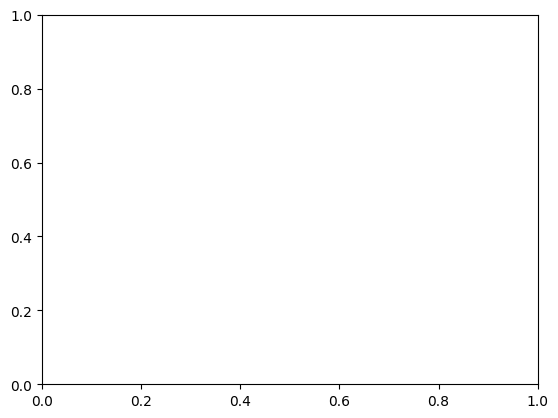

In [524]:
plt.scatter(d1, d2)

In [469]:
# # depths
# n2 = jnp.sum(local_weights > 0, axis = 1)
# k = jnp.ceil((n2+1)*(1-alpha))/n2
# d1 = phi_tukey(p1, p1, local_weights) - 1/ntrain
# q1 = jnp.quantile(d1, 1-k, axis = 1)

# d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
# np.mean(d2 >= q1)

In [476]:
def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, rng):
    
    xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.exp(-jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
    local_weights = dist / (jnp.sum(dist) + 1)
    
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights, dval
phi_quantile = jit(phi_quantile, static_argnames='depth_fn')

In [504]:
def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, rng):
    dist = jnp.exp(-jnp.max(jnp.abs(xval - xtest), axis = (1, 2)))
    dist = dist / (1 + dist)
    local_weights = dist / (jnp.sum(dist) + 1)
    
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights, dval
phi_quantile = jit(phi_quantile, static_argnames='depth_fn')

In [505]:
##### random basis
phi = phi_slice(rng4, p, 100)
cover = []
for k in trange(ntest):
    rng, key = random.split(rng)
    qval, local_weights, dval = phi_quantile(p1, x1[:,None,:], 
                                             x2[:,None,:][k] + 1e-2 * jax.random.normal(rng, x2.shape),
                                             0.1, 'tukey', rng = key)
    dtest = phi_depth(p2[k], p1, local_weights, 'tukey')
    cover.append(dtest >= qval)

np.mean(cover)

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(0.898)

In [7]:
key = random.PRNGKey(0)

In [11]:
# generate
ntrain, ntest, p = 1000, 200, 100   
alpha = 0.1
lam = 0.1

key, rng1, rng2, rng3 = random.split(key, 4)
x1 = random.normal(rng1, (ntrain, p))
x2 = random.normal(rng2, (ntest, p))

t = jnp.linspace(0, 1, ntrain+ntest)
mu = 1 + jnp.sin(6 * jnp.pi * t)

x1 = mu[:ntrain,None] + x1
x2 = mu[ntrain:,None] + x2

y1 = mu[:ntrain,None]/5 * random.normal(rng1, (ntrain, p))
y2 = mu[ntrain:,None]/5 * random.normal(rng1, (ntest, p))

# weight
local_weights = localizer(x1, x2, lam)

# slice
phi = phi_slice(rng3, p, 200)
p1 = y1 @ phi
p2 = y2 @ phi

# depths
k = jnp.ceil((n+1)*(1-alpha))/n
d1 = phi_tukey(p1, p1, local_weights)
q1 = jnp.quantile(d1, 1-k, axis = 1)

d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
np.mean(d2 >= q1)

Array(0.995, dtype=float32)

In [41]:
def weighted_tukey1d(pref, ptarget, weights):
    f = jnp.sum(weights * (pref < ptarget))
    f = jnp.nan_to_num(f)
    return 1 - jnp.abs(1 - 2 * f)
weighted_tukey1d = vmap(weighted_tukey1d, (None, 0, None))
weighted_tukey1d = vmap(weighted_tukey1d, (1, 1, None))
# weighted_tukey1d = jit(weighted_tukey1d)

def phi_tukey(pref, ptarget, weights):
    depth = jnp.mean(weighted_tukey1d(pref, ptarget, weights), axis = 0)
    return jnp.clip(depth, 0, 1)
phi_tukey = vmap(phi_tukey, (None, None, 0))

In [63]:
k = jnp.ceil((n+1)*(1-alpha))/n
d1 = phi_tukey(p1, p1, local_weights)
q1 = jnp.quantile(d1, 1-k, axis = 1)

ValueError: Incompatible shapes for broadcasting: shapes=[(100,), (100, 20)]

In [43]:
d2 = jnp.diag(phi_tukey(p1, p2, local_weights))
np.mean(d2 >= q1)

Array(0.97999996, dtype=float32)

In [39]:
def weighted_tukey1d2(pref, ptarget, weights):
    f = jnp.sum(weights * (pref < ptarget))
    f = jnp.nan_to_num(f)
    return 1 - jnp.abs(1 - 2 * f)
weighted_tukey1d2 = vmap(weighted_tukey1d2, (None, 0, 0))
weighted_tukey1d2 = vmap(weighted_tukey1d2, (1, 1, None))

In [29]:
d2 = np.mean(weighted_tukey1d2(p1, p2, local_weights), axis = 0)

In [30]:
np.mean(d2 >= q1)

Array(0.97999996, dtype=float32)

In [657]:
n_sim = 100
cover = np.zeros(n_sim)

key = 0
n, p = 1000, 200   
alpha = 0.1
lam = 0.1

for i in trange(n_sim):
    # generate
    key += 1
    rng1 = random.PRNGKey(key+1)
    rng2 = random.PRNGKey(key+2)
    x1 = random.normal(rng1, (n, p))
    x2 = random.normal(rng2, (n, p))
    
    t = jnp.linspace(0, 1, n)
    mu = 1 + 3 * t + jnp.sin(2 * jnp.pi * t)
    
    x1 = mu[:,None] + x1
    x2 = mu[:,None] + x2

    y1 = x1 + mu[:,None]/5 * random.normal(rng1, (n, p))
    y2 = x2 + mu[:,None]/5 * random.normal(rng1, (n, p))

    # weight
    local_weights = localizer(x1, x2, lam)

    # slice
    phi = phi_slice(rng, p, 100)
    p1 = y1 @ phi
    p2 = y2 @ phi

    # depths
    d1 = phi_tukey(p1, p1, local_weights)
    d2 = phi_tukey(p1, p2, local_weights)

    # threshold
    idx = int(n - jnp.ceil((n+1)*(1-alpha)))
    q1 = jnp.sort(d1)[idx]

    # cover?
    cover[i] = np.mean(d2 >= q1)

  0%|          | 0/100 [00:00<?, ?it/s]

Array(0.29882443, dtype=float32)

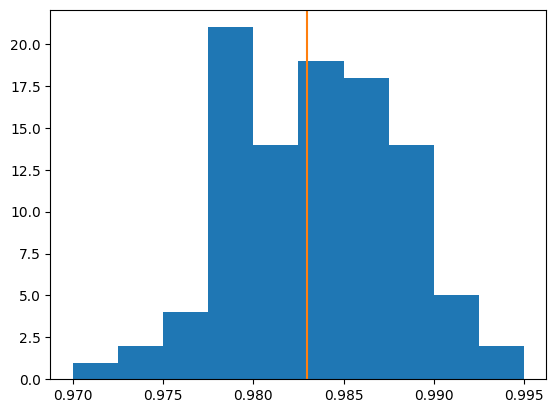

In [647]:
plt.hist(cover)
plt.axvline(np.median(cover), c = 'C1')
plt.show()

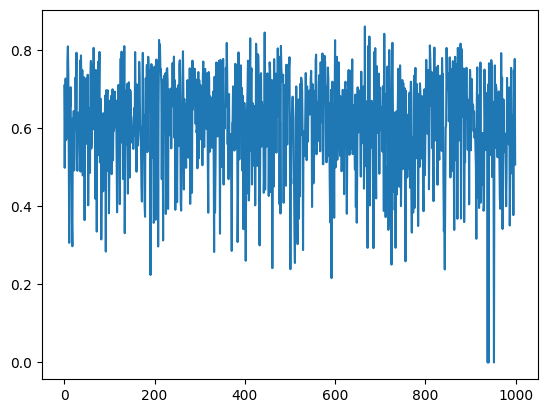

In [648]:
plt.plot(d2)